# Buy ‘Til You Die: Predict Customer Lifetime Value (CLV)
- Goal: to predict the transaction frequency of customers and their churn risks.
    - For example: A customer who used to purchase once every 20 days on average, but has remained inactive for 50 days, must be rated an increased churn risk. She may be on the brink of turning away from our business, towards a competitor’s product range. 
- **Buy ’Til You Die Models** (BTYD) : from the “birth” of a customer (when she places her first order with our business) to the day she “dies” (when she turns to a competitor and thus is dead to us, the enterprise she’s spurned).
- In contractual settings, Customers sign term-limited contracts with internet providers, mobile phone networks, insurance companies, and subscription-based service providers. Enterprises in contractual settings can develop a much clearer view on customers that have a propensity to churn.
    - Contractual churn problems, to which we can apply a battery of well-known models such as logistic regression, random forests, gradient boost approaches, and other classifiers.
- In a non-contractual business environment, circumstances are more murky. 
    - Most classification models we typically apply to customer churn problems in contractual business settings are not applicable to non-contractual settings. Churn dates are not transparent.
    - We need to analyze the purchase behavior of customers by making distributional assumptions. A probability model will also enable us to predict the purchase volume.
- The model we are going to build will enable marketing teams to set the focus of their efforts on those customers for whom the model identifies a turning point.
    - the Beta-Geometric/Negative Binomial (BG/NBD) model,
    - combined with the Gamma-Gamma model for estimating the customer lifetime value.
    - Model outputs:
        - **CLV** denotes the customer lifetime value: in this case, the revenues over a chosen period of time, for instance 12 months.
        - The four predict columns forecast the **number of purchase transactions** we can expect over the next 10, 30, 60, and 90 days from each customer.
        - `prob_alive` estimates the customer’s probability of being alive. Its complement `(1 — p)` is equivalent to the customer’s **churn risk**: of turning away from our business and favoring a competitor.


- Reference:
    - [Buy ‘Til You Die: Predict Customer Lifetime Value in Python](https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0)

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(rc={'image.cmap': 'coolwarm'})
pd.options.display.float_format = '{:,.2f}'.format


from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes.plotting import (
    plot_frequency_recency_matrix, 
    plot_probability_alive_matrix, 
    plot_period_transactions,
    plot_calibration_purchases_vs_holdout_purchases,
    plot_history_alive
)

import re
from datetime import timedelta

## 1. Data Prepration
- Data Source: [Online Retail Transactions](https://archive.ics.uci.edu/dataset/352/online+retail)

In [229]:
df = pd.read_excel("../../../data/common_datasets/online-retail.xlsx")

In [230]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,"12,680.00",France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,"12,680.00",France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,"12,680.00",France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,"12,680.00",France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,"12,680.00",France


In [231]:
col_list = []
for col_name in df.columns:
    if col_name == "CustomerID":
        col_name = "customer_id"
    else:
        col_name = "_".join([col.lower() for col in re.findall('[A-Z][^A-Z]*', col_name)])
    col_list.append(col_name)

In [232]:
df.columns = col_list

In [233]:
df.shape

(541909, 8)

In [234]:
df = df[~df['customer_id'].isna()]

In [235]:
# Filter those transactions start with letter 'c', it indicates a cancellation, 'a' it indicates adjust bad dept
df = df[~df["invoice_no"].astype(str).str.startswith(("A","C"))]
# Convert customer_id from float to string
df['customer_id'] = df['customer_id'].astype(str).str.split(".").str[0]

In [236]:
df["invoice_date"] = df['invoice_date'].dt.date # normalize to date only

In [237]:
df['total_revenue'] = df['quantity']*df['unit_price']

In [238]:
df.query("invoice_no == 581587") # 581587 A563185

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_revenue
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09,1.95,12680,France,23.40
541895,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09,1.65,12680,France,19.80
541896,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09,1.65,12680,France,19.80
541897,581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09,3.75,12680,France,15.00
541898,581587,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09,3.75,12680,France,15.00
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09,3.75,12680,France,15.00
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09,3.75,12680,France,15.00
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09,1.95,12680,France,15.60
541902,581587,22629,SPACEBOY LUNCH BOX,12,2011-12-09,1.95,12680,France,23.40
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09,4.15,12680,France,16.60


In [239]:
# review the categorical variables
df.describe(include='object').T

,count,unique,top,freq
invoice_no,397924,18536,576339,542
stock_code,397924,3665,85123A,2035
description,397924,3877,WHITE HANGING HEART T-LIGHT HOLDER,2028
invoice_date,397924,305,2011-11-06,3423
customer_id,397924,4339,17841,7847
country,397924,37,United Kingdom,354345


- The dataset comprises 4,339 unique customer IDs and 305 invoice dates within the time horizon.

In [240]:
# review the numerical variables
df.describe()

,quantity,unit_price,total_revenue
count,"397,924.00","397,924.00","397,924.00"
mean,13.02,3.12,22.39
std,180.42,22.10,309.06
min,1.00,0.00,0.00
25%,2.00,1.25,4.68
50%,6.00,1.95,11.80
75%,12.00,3.75,19.80
max,"80,995.00","8,142.75","168,469.60"


In [241]:
# aggregation as per invoice_no: sum of all items purchased within the invoice
df_orders = df.groupby(['invoice_no','customer_id', 'invoice_date']).agg({'total_revenue': 'sum'}).reset_index() 

In [242]:
df_orders['invoice_date'].max(), df_orders['invoice_date'].min() 

(datetime.date(2011, 12, 9), datetime.date(2010, 12, 1))

## 2. Raw Recency, Frequency, and Monetary Metrics
- The next step is to turn our raw transactional data into the recency, frequency, monetary and tenure (T) metrics we need to provide to the CLV models. 
    - **Lifetimes** package has the function to do it `summary_data_from_transaction_data()`.
        - Note 1: The `observation_period_end` date would usually represent the most recent order date within your dataframe.
        - Note 2: he first transaction by default is **not included** while calculating the frequency and monetary value. 
            - To include it, just set the parameter `include_first_transaction` to True. To use the data with some fitters from the lifetimes package, this parameter must be set to False
        - Note 3: recency defintion in Lifetimes package is different from the recency definition below
            - For the `customer_id=12347`, `recency` is the number of days between her first (2010-12-07) and her latest transaction (2011-12-07), which is 365 days. 
            - A bit counter-intuitively, it does not measure the days since her latest purchase.
- `recency_date` represent the `max()` value from the `invoice_date` column for each customer
    - `recency` metric represents the time delta between the **current date** and the `recency_date` in days. 
```Python
# create df_customers
df_customers = pd.DataFrame(df['customer_id'].unique())
df_customers.columns = ['customer_id']

# for each customer, create recency_date, which is the max() value from the invoice_date column for each customer
df_recency = df.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency.columns = ['customer_id','recency_date']
df_customers = df_customers.merge(df_recency, on='customer_id')

# calculate recency
# divide by np.timedelta64(1, 'D') is to convert "timedelta" values in the 'recency' column to the number of days (float64)
# round to express the value in integer
df_customers['recency'] = round((pd.to_datetime('today') - df_customers['recency_date']) \
                                / np.timedelta64(1, 'D') ).astype(int)

```
- `Tenure`, or T, is a measure of how long a given customer has been with the company. 
    - The `tenure_date` is effectively the opposite of the `recency_date` and is calculated from the `min()` of the `invoice_date`
    - `tenure` metric is the time delta between the `tenure_date` and the **current date** in days, expressed as an integer.

```Python
df_tenure = df.groupby('customer_id')['invoice_date'].min().reset_index()
df_tenure.columns = ['customer_id','tenure_date']
df_customers = df_customers.merge(df_tenure, on='customer_id')

df_customers['tenure'] = round((pd.to_datetime('today') - df_customers['tenure_date']) \
                               / np.timedelta64(1, 'D') ).astype(int)
```

- The Lifetimes package will compute these values for us. To understand their definitions, let’s demonstrate how they can be determined for a chosen customer: ID = 14527.

In [243]:
customer_example = df_orders.query("customer_id == '12347'")
customer_example

,invoice_no,customer_id,invoice_date,total_revenue
548,537626,12347,2010-12-07,711.79
2205,542237,12347,2011-01-26,475.39
4942,549222,12347,2011-04-07,636.25
7844,556201,12347,2011-06-09,382.52
10173,562032,12347,2011-08-02,584.91
15066,573511,12347,2011-10-31,"1,294.32"
18367,581180,12347,2011-12-07,224.82


In [244]:
customer_birthday = customer_example['invoice_date'].min()      # 2010–12–05
customer_latest_trans = customer_example['invoice_date'].max()  # 2011–12–07
latest_date = df_orders['invoice_date'].max()                   # 2011–12–09: the end date of our analytical horizon

recency = customer_latest_trans - customer_birthday
longevity_T = latest_date - customer_birthday
frequency = customer_example.shape[0] - 1 # -1 as BG/NBD models focus on repeat purchases, it omits the initial transaction.
monetary_value = customer_example.loc[2205:,'total_revenue'].mean() # not include the first transaction @ index = 548
print(f"Recency: {recency.days}\nAge or Longevity (T): {longevity_T.days}\nFrequency: {frequency}\nMonetary Value: {monetary_value:.2f}")

Recency: 365
Age or Longevity (T): 367
Frequency: 6
Monetary Value: 599.70


In [245]:
df_rfmt = summary_data_from_transaction_data(df_orders, 
                                             customer_id_col='customer_id',
                                             datetime_col='invoice_date',
                                             monetary_value_col='total_revenue',
                                             observation_period_end='2011-12-09 12:50:00',
                                            #  include_first_transaction=True
                                             )

In [246]:
df_rfmt.head()

,frequency,recency,T,monetary_value
customer_id,,,,
12346,0.00,0.00,325.00,0.00
12347,6.00,365.00,367.00,599.70
12348,3.00,283.00,358.00,301.48
12349,0.00,0.00,18.00,0.00
12350,0.00,0.00,310.00,0.00


In [247]:
df_rfmt[df_rfmt.index == '14527']

,frequency,recency,T,monetary_value
customer_id,,,,
14527,53.00,367.00,369.00,155.02


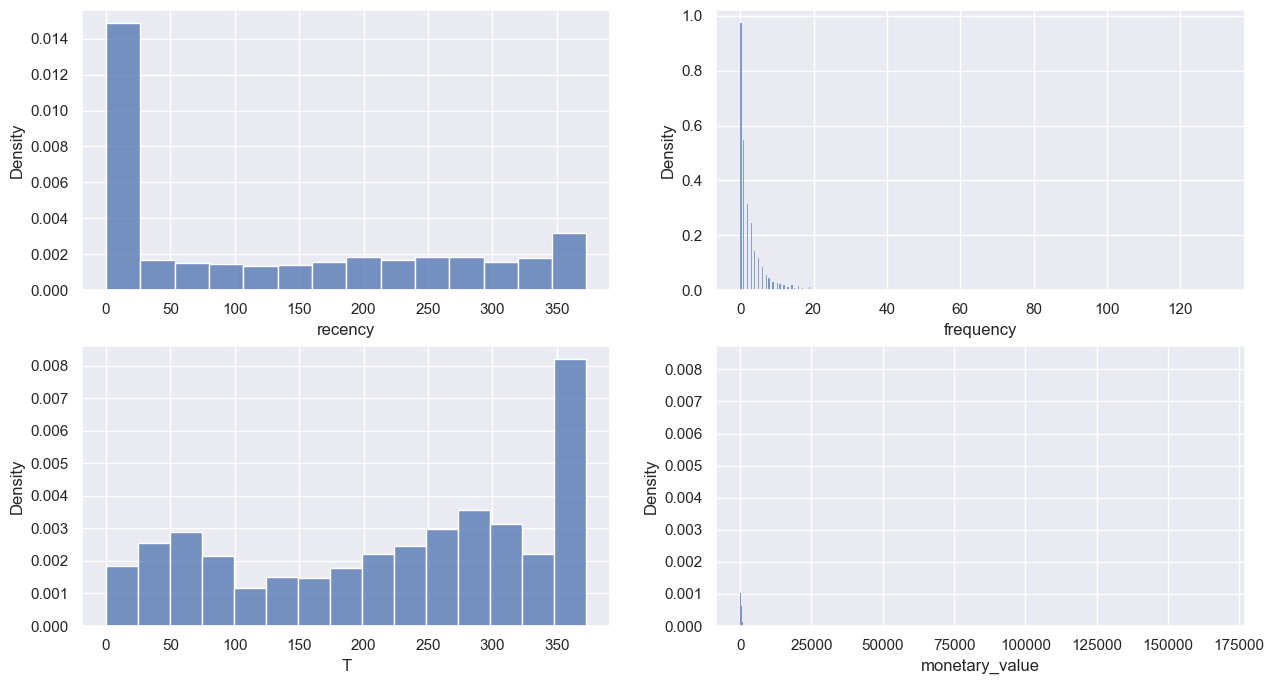

In [248]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,8))
for idx, metric in enumerate(['recency', 'frequency', 'T', 'monetary_value']):
    sns.histplot(df_rfmt[metric], stat='density', ax=eval(f"ax{idx+1}"))
plt.show()

- The data are strongly skewed, with most customers have placed a single low value order
- T plot show the peaks and troughs indicating that this business is strongly seasonal
    - The spike @ 360 days, it indicates the start period of this analysis

## Train Test Split
- Lifetimes uses the terms **calibration** and **holdout** periods for what we would label the training and test datasets in most other applications.
- `calibration_and_holdout_data()` takes as its arguments the chosen end of the calibration period and the end of the observation period.

### How to choose hold out period ?
- This particular dataset comprises 400,000 records, but they are spread over 4,000 customers and cover just two years. 
- Many smaller customers submit their repeat orders a couple of months apart. 
- If we set the holdout period to a small number of time periods, it will contain only a few repeat transactions for small customers. We risk that it does not fully reflect their demand patterns. 
- In this dataset, a holdout period shorter than 100 days does not work well in this case. 
    - Ideally it should be close to 200 days. 
- Yet if we reserve too many days for the holdout period, the same problem can afflict the training phase: a training period as short as 365 days may not catch enough customer-specific transactions to pin down their demand patterns.
- Alternative: It would be preferable to create the holdout dataset by **randomly drawing customers from the entire dataset** and then check whether the purchase behavior of the customers in the training dataset differs from the behavior of the holdout customers. 
    - But many of Lifetimes’ evaluation functions take a time period t as their parameter and would not work if calibration and holdout transactions overlap in the same period of time, even if the customers are kept separate.

In [249]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df_orders["invoice_date"].max()              # end date of observations


max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print(f"End of calibration period: {max_cal_date}")
print(f"End of observations      : {max_date}")

End of calibration period: 2011-04-13
End of observations      : 2011-12-09


In [250]:
summary_cal_holdout = calibration_and_holdout_data(transactions=df_orders, 
                                                   customer_id_col='customer_id', 
                                                   datetime_col='invoice_date',
                                                   monetary_value_col='total_revenue',
                                                   calibration_period_end=max_cal_date,  # 2011-04-13
                                                   observation_period_end=max_date,      # 2011-12-09
                                                   freq = "D"
                                                   )

In [251]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
12346,0.00,0.00,85.00,0.00,0.00,0.00,240.00
12347,2.00,121.00,127.00,555.82,4.00,621.64,240.00
12348,2.00,110.00,118.00,297.22,1.00,310.00,240.00
12350,0.00,0.00,70.00,0.00,0.00,0.00,240.00
12352,3.00,34.00,56.00,421.77,3.00,314.74,240.00


In [252]:
summary_cal_holdout.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"2,299.00","2,299.00","2,299.00","2,299.00","2,299.00","2,299.00","2,299.00"
mean,1.10,30.87,79.32,175.90,3.40,316.51,240.00
std,2.49,43.81,43.27,438.19,5.47,600.80,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,240.00
25%,0.00,0.00,42.00,0.00,1.00,51.10,240.00
50%,0.00,0.00,82.00,0.00,2.00,234.32,240.00
75%,1.00,65.00,124.00,252.22,4.00,400.79,240.00
max,35.00,133.00,133.00,"8,030.17",96.00,"21,535.90",240.00


## BG/NBD model
- In non-contractual business settings, the purchase behavior of customers does not follow a deterministic trend. 
    - Both **demand** levels and **churn rates** are random variables. 
- A distributional model like BG/NBD describes the random processes that influence the customer behavior, individually and in aggregate.
- Beta Geometric Negative Binomial Distribution or BG/NBD model is based on the original Pareto/NBD model for CLV which was formulated by Schmittlein, Morrison, and Colombo in 1987.
- The method relies on four distributional assumptions to model the uncertainties:
    - The **number of orders** a customer will place in a time period follows a **Poisson** distribution with transaction rate `lambda`. 
        - This Poisson count distribution is equivalent to the assumption that the time between transactions follows an exponential distribution with the same transaction rate lambda.
    - The **demand varies** independently between customers: heterogeneity in lambda. 
        - The variation in lambda is a random variable that follows a **Gamma** distribution with shape parameter `r` and scale `alpha`.
    - After any purchase, a customer may become inactive with probability `p` and turns away from the business. 
        - The churn risk follows a **Geometric** distribution.
    - The** churn risk varies** independently between customers: heterogeneity in `p`. 
        - The variation of the churn or dropout probability `p` is a random variable that follows a **Beta** distribution.


In [18]:
from lifetimes import BetaGeoFitter

In [19]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


- `plot_frequency_recency_matrix()` is to create predictions and visualise once the BG/NBD model has been fitted to the data. 
- The matrix has 
    - The customer’s **recency** on the Y axis 
    - The **frequency** on the X axis 
    - The heatmap component is showing the predicted number of future purchases customers at intersecting points will make in one unit of time. 
- The customers most likely to order are those who’ve placed lots of previous orders and have been seen relatively recently.



In [20]:
# plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# plot_frequency_recency_matrix(bgf)
# plt.show()

- Plot the probability that each customer is "alive" based on their frequency and recency.

In [21]:
# plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# plot_probability_alive_matrix(bgf)
# plt.show()

### Predict the number of orders each customer will make during a time period
- Use the BG/NBD model data to predict the number of purchases each customer will make in some forthcoming periods.

In [22]:
# set t to 90 so we predicted for the 90 days after the end of the observation period
t = 90
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])

In [23]:
df_rfmt.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
16422,47.0,352.0,369.0,702.472340,9.822565
13798,52.0,371.0,372.0,706.650962,10.779581
14527,53.0,367.0,369.0,155.016415,11.058774
13089,65.0,367.0,369.0,893.714308,13.524270
12971,70.0,369.0,372.0,159.211286,14.452417
14606,88.0,372.0,373.0,135.890114,18.084835
15311,89.0,373.0,373.0,677.729438,18.288586
17841,111.0,372.0,373.0,364.452162,22.767661
12748,113.0,373.0,373.0,298.360885,23.175061


- Most customers in the dataset aren’t going to order in the next 90 days.
- Obviously, this is based only on the customers in the dataset, so this prediction wouldn’t include any customers acquired since then or during the 90 day period, so will be higher in reality.

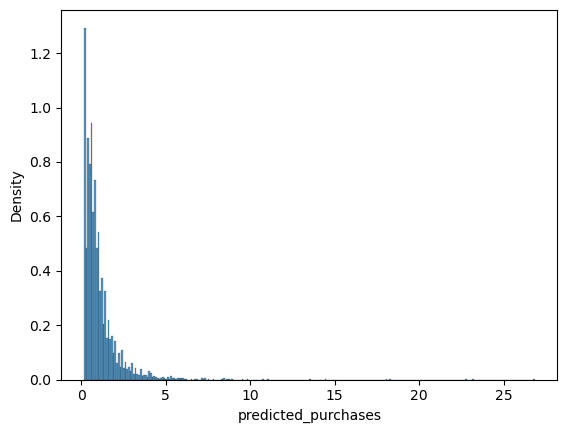

In [24]:
sns.histplot(df_rfmt['predicted_purchases'], stat='density');

- `plot_period_transactions()` function will compare the actual observations from a previous time period to the model’s prediction for that time period. As you can see, the two are almost identical, which shows that the model is a very good fit and predicts the number of periods in the calibration period quite well.

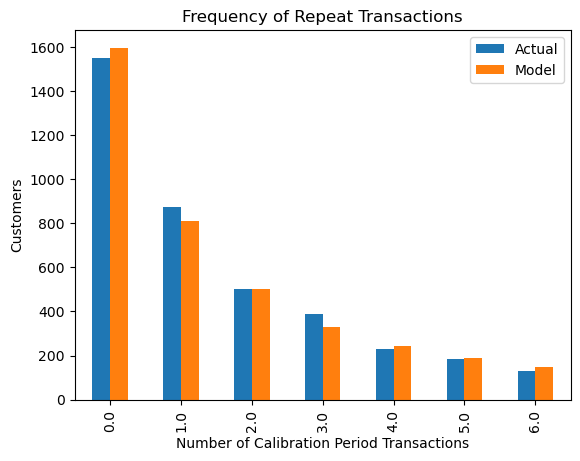

In [25]:
plot_period_transactions(bgf);

### Using a holdout group
- The **calibration period** starts from the date of the first transaction in your dataset and ends here on 2011-10-10. 
- The **observation period** starts from 2011-10-10 and this ends on 2011-12-09.
- `frequency_holdout` value containing the actual number of orders they placed in the holdout period.

In [26]:
df_orders['invoice_date'].describe()

count                            18566
mean     2011-07-01 14:04:43.983625984
min                2010-12-01 08:26:00
25%                2011-03-30 13:56:15
50%                2011-07-12 14:37:00
75%                2011-10-12 13:16:15
max                2011-12-09 12:50:00
Name: invoice_date, dtype: object

In [27]:
df_orders.query("invoice_date <= '2011-10-10'").shape[0] / df_orders.shape[0]

0.7381234514704298

In [40]:
summary_cal_holdout = calibration_and_holdout_data(df_orders, 
                                                   'customer_id', 
                                                   'invoice_date',
                                                    calibration_period_end='2011-10-10',
                                                    observation_period_end='2011-12-09')

In [41]:
summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
14911,95.0,310.0,313.0,36.0,60.0
12748,84.0,312.0,313.0,28.0,60.0
17841,85.0,310.0,313.0,26.0,60.0
15311,70.0,310.0,313.0,18.0,60.0
14606,72.0,307.0,313.0,16.0,60.0


In [42]:
# Re-fit the model on the calibration period
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3721 subjects, a: 0.00, alpha: 69.89, b: 15536.39, r: 0.76>

- `plot_calibration_purchases_vs_holdout_purchases()` to plot the predicted frequency of orders in the holdout period to the actual value.

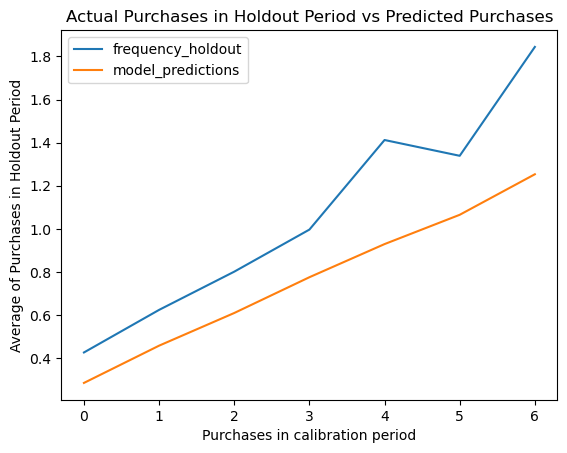

In [43]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

### Get predictions for a specific customer
- The customer in the index 1 should place 5.65 orders in the next 365 days

In [44]:
t = 365
individual = df_rfmt.iloc[1]
bgf.predict(t, 
            individual['frequency'], 
            individual['recency'], 
            individual['T'])

5.6514714519129905

### Plot customer probability history
- One of the main concepts of CLV models, like Buy Till You Die (BTYD) is that active customers will purchase “randomly” around their mean transaction rate.
    - For example: if a customer shops every 30 days on average, their orders might come every 20-40 days

- Customer 12347 from our original dataset, we can see that they’ve placed 7 orders since they were first acquired on 2010-12-07 about 365 days ago.

In [65]:
example_customer_orders = df_orders.loc[df_orders['customer_id'] == "12347"]
example_customer_orders

,invoice_no,customer_id,invoice_date,total_revenue
549,537626,12347,2010-12-07 14:57:00,711.79
2212,542237,12347,2011-01-26 14:30:00,475.39
4957,549222,12347,2011-04-07 10:43:00,636.25
7867,556201,12347,2011-06-09 13:01:00,382.52
10197,562032,12347,2011-08-02 08:48:00,584.91
15094,573511,12347,2011-10-31 12:25:00,1294.32
18397,581180,12347,2011-12-07 15:52:00,224.82


In [67]:
# days_since_birth = 365
# plot_history_alive(bgf, days_since_birth, example_customer_orders, 'invoice_date')

## Gamma-Gamma Model
- Gamma-Gamma model was written by Peter Fader and Bruce Hardie in 2013 and was based on one of Fader’s earlier models for predicting spend.
- Assumption: monetary value and frequency are independent variables and aren’t correlated with each other. 
- Goal: to predict the monetary value of the orders the customer will place

In [68]:
returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
16446,1.0,205.0,205.0,168469.6000,0.599739
15749,1.0,97.0,332.0,21535.9000,0.408933
18102,25.0,367.0,367.0,9349.4772,5.330370
12536,1.0,16.0,59.0,8322.1200,1.283407
12415,15.0,313.0,337.0,7860.2100,3.506760


In [69]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [70]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [72]:
# predicted average order value (aov) for each customer. 
predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
)
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)

In [73]:
aov_df.head()

,aov
customer_id,
16446,78051.285456
15749,10173.137080
18102,8951.861919
12415,7323.918818
17450,7105.093878


- Average Order Value (AOV) plot: Most of our customers are going to spend only a modest amount, but there’s a long-tail of higher value customers and a little group of really big spenders on the far right.

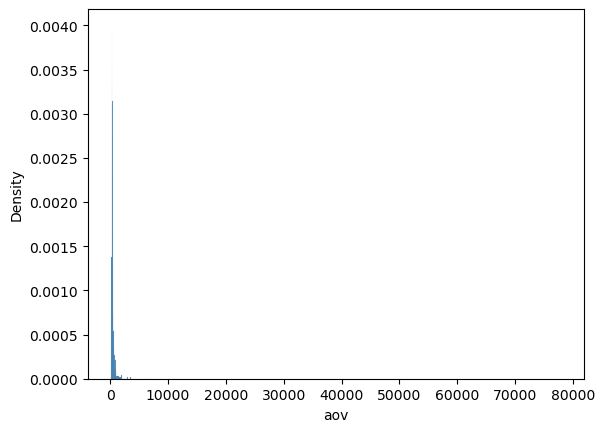

In [75]:
ax = sns.histplot(aov_df['aov'], stat='density');

### Segment customers by their Average Order Value (AOV)

#### Method 1: Quantile-based discretization or Binning
- Bin 1 contains the low CLV customers who have an average value of £220.87, the averages go up in each bin, 
- Bin 5 has the highest CLV customers with an average value of £995.95. 
    - However, there’s quite a spread at Bin 5, where it includes customers from £480.89 to £78051.28
- This is a long-tail distribution &#8594; K-mean clustering

In [76]:
aov_df['aov_bin'] = pd.qcut(aov_df['aov'], q=5, labels=[1, 2, 3, 4, 5])
aov_df = aov_df.reset_index()

In [80]:
aov_df.groupby('aov_bin').agg(
    count=('customer_id', 'count'),
    min_aov=('aov', min),
    max_aov=('aov', max),
    std_aov=('aov', 'std'),    
    mean_aov=('aov', 'mean')
).sort_values(by='mean_aov')

,count,min_aov,max_aov,std_aov,mean_aov
aov_bin,,,,,
1,558,47.048956,262.414928,33.087555,220.876536
2,558,262.728865,315.218776,14.721693,288.545256
3,558,315.231126,378.261066,18.114800,346.538339
4,558,378.441724,480.345312,29.050575,420.939367
5,558,480.893801,78051.285456,3374.574619,995.951175


#### Method 2: K-means Clustering
- Note: cluster numbers aren’t sorted in order, you can clearly see the differences in AOV across the five clusters. 
- Cluster 4 contains low spenders, averaging ~£329.96 per order, while clusters 1 and 2 include some very big spenders.

In [84]:
from sklearn.cluster import KMeans

aov_clusters = aov_df[['aov']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(aov_clusters)

aov_clusters = aov_clusters.assign(cluster=kmeans.labels_)
unsorted_aov = aov_clusters.groupby('cluster')['aov'].mean().sort_values(ascending=True).to_frame()
unsorted_aov

,aov
cluster,
4,329.967945
0,752.552292
3,2340.657131
2,7953.457890
1,78051.285456


In [ ]:
# plt.figure(figsize=(8,8))
# sns.scatterplot(data = aov_clusters, x='frequency', y='monetary', hue='clusters')

## Customer Lifetime Value
- BG/NBD model to predict the number of orders 
- Gamma-Gamma model to predict their values using the Gamma-Gamma model’s `customer_lifetime_value()` function which requires
    - `bgf` model
    - the recency, frequency, monetary_value, and T data for each customers. 
    - The `time` parameter is in **months** and defines how many months into the future we wish to predict.
    - `discount_rate` relates to discounted cash flow (DCF), which is a financial measure for adjusting the cost of capital. This is a monthly adjusted discount rate and uses a default value of 0.01 in this package. 

In [87]:
# re-fit the BetaGeoFitter BG/NBD model to our dataset for the returning customers
bgf.fit(returning_customers['frequency'], 
        returning_customers['recency'], 
        returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 2790 subjects, a: 0.01, alpha: 108.89, b: 0.16, r: 1.94>

In [88]:
# predicts your best customers to be over the next 12 months.
preds = ggf.customer_lifetime_value(
    bgf,
    returning_customers['frequency'],
    returning_customers['recency'],
    returning_customers['T'],
    returning_customers['monetary_value'],
    time = 12,
    discount_rate = 0.01
)

preds = preds.to_frame().reset_index()

In [90]:
preds.sort_values(by='clv', ascending=False).head()

,customer_id,clv
1938,16446,231839.793106
1111,14646,207563.198151
2706,18102,170553.506139
2413,17450,140365.469522
834,14096,109633.219359
